In [ ]:
# Purpose:
# Cross validate total season data to predict win/loss ratio

# Cross Validation

In [1]:
# Imports and display options
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error

import seaborn as sns
from seaborn import plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

import pickle

pd.options.display.float_format = '{:20,.2f}'.format
pd.options.display.max_columns = 100
pd.options.display.max_rows = 20

%matplotlib inline

/Users/maludee/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Import the cleaned and processed NBA datafile (2006-2016, data from the whole season)
with open("team_stats.pkl", 'rb') as picklefile:
    team_stats = pickle.load(picklefile)

,team,season,avg_field_goals,avg_fg_att,avg_fg3_pct,avg_steals,avg_salary,avg_age,avg_per,avg_pct_started,avg_wl_ratio,strong_link,weak_link,opp_3_pct,opp_fg_pct,opp_fg_att,pace,log_avg_wl
0,Atlanta_Hawks,2006,387.00,866.80,0.28,73.00,"4,992,921.60",22.80,14.56,0.91,0.46,0.75,-0.68,0.37,0.48,6433,90.40,-0.77
1,Atlanta_Hawks,2007,347.00,763.40,0.28,68.40,"5,066,493.80",22.20,15.82,0.66,0.58,0.75,-0.39,0.38,0.47,6335,90.00,-0.55
2,Atlanta_Hawks,2008,418.40,925.40,0.22,76.60,"7,488,752.00",23.80,16.08,0.86,0.82,0.48,-0.29,0.36,0.46,6733,91.10,-0.20
3,Atlanta_Hawks,2009,414.40,898.00,0.28,77.20,"9,775,806.60",24.80,16.94,0.86,1.34,0.35,-0.30,0.35,0.45,6609,89.60,0.29
4,Atlanta_Hawks,2010,435.20,908.00,0.41,80.80,"8,760,402.20",25.80,17.08,0.97,1.83,0.43,-0.30,0.34,0.46,6623,90.10,0.60


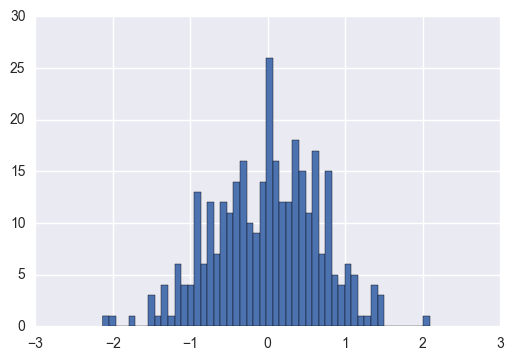

In [3]:
# Make a column for log wl_ratio because then it'll be normalized
team_stats['log_avg_wl'] = np.log(team_stats.avg_wl_ratio)

# Check if that had a normal distribution
team_stats.log_avg_wl.hist(bins = 50);

team_stats.head()

In [4]:
# Drop columns that will not be used in the model
team_stats = team_stats.drop('team', 1)
team_stats = team_stats.drop('season', 1)
team_stats = team_stats.drop('avg_wl_ratio', 1)
team_stats = team_stats.drop('avg_field_goals', 1)

In [5]:
# Normalize the team_stats dataframe between 0 and 1 (between -1 and 1 would be team_stats.mean()/ same as below)
team_norm = (team_stats - team_stats.min()) / (team_stats.max() - team_stats.min())
#team_norm = (team_stats - team_stats.mean()) / (team_stats.std())
team_norm.head(3)

,avg_fg_att,avg_fg3_pct,avg_steals,avg_salary,avg_age,avg_per,avg_pct_started,strong_link,weak_link,opp_3_pct,opp_fg_pct,opp_fg_att,pace,log_avg_wl
0,0.68,0.33,0.56,0.20,0.10,0.35,0.87,0.58,0.18,0.58,0.82,0.58,0.29,0.32
1,0.52,0.31,0.50,0.21,0.05,0.50,0.40,0.59,0.64,0.66,0.65,0.54,0.26,0.37
2,0.76,0.17,0.60,0.38,0.17,0.54,0.77,0.35,0.81,0.52,0.61,0.72,0.34,0.46


In [6]:
# Add intercept column
team_norm['intercept'] = 1

In [7]:
team_norm.shape

(329, 15)

In [46]:
# Desired outcome variable
y = team_norm.log_avg_wl

# Full set of features 
X = team_norm.drop(['log_avg_wl'], 1)

# Set a fold object to organize cross validation
kf = KFold(n = len(X), n_folds = 3, shuffle = True)
all_scores = []

# Set the number of features to remove from model based on pvalues
# Try different numbers here
n_to_remove_from_model = 8

# Get indices of corresponding train & test
for train, test in kf:
    x_train = X.iloc[train]
    y_train = y.iloc[train]
    x_test = X.iloc[test]
    y_test = y.iloc[test]
    pvals = []
    sig_cols = []
    
    model = sm.OLS(y_train, x_train)
    est = model.fit()
    pvals = est.pvalues.sort_values()
    
    # Eliminate features iteratively
    for i in range(n_to_remove_from_model): 
        # Recalculate pvalue
        pvals = pvals[:-1]
#         print pvals
        # Remove one feature at a time
        feature_keep = pvals.index

        x_train = x_train[feature_keep]
        x_test_red = x_test[feature_keep]
        model = sm.OLS(y_train, x_train)
        est = model.fit()
        pvals = est.pvalues.sort_values()
        y_train_pred = est.predict(x_train)
        y_test_pred = est.predict(x_test_red)

    r_2 = est.rsquared
    all_scores.append(r_2)
     #Summary of R2 and pvalues for each of the five models
    #print(r_2)
    #print(est.pvalues.sort_index())
    
# Summary of the last model (out of 5)
est.summary()

#pvals

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_avg_wl   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     156.3
Date:                Thu, 26 Jan 2017   Prob (F-statistic):           2.12e-69
Time:                        22:54:43   Log-Likelihood:                 261.22
No. Observations:                 220   AIC:                            -510.4
Df Residuals:                     214   BIC:                            -490.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
opp_fg_pct         -0.3183      0.029    -11.031      0.000        -0.375    -0.261
avg_per             0.3505      0.032     11.058      0.000         0.288     0.413
intercept           0.3552      0.035     10.267      0.000         0.287     0.423
avg_pct_started     0.1985      0.032      6.291      0.000         0.136     0.261
avg_age             0.1387      0.029      4.739      0.000         0.081     0.196
weak_link          -0.1084      0.024     -4.531      0.000        -0.156    -0.061
==============================================================================
Omnibus:                       15.986   Durbin-Watson:                   1.472
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.398
Skew:                           0.361   Prob(JB):                     2.51e-07
Kurtosis:                       4.672   Cond. No.                         14.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

0.787274551045
0.785482220325


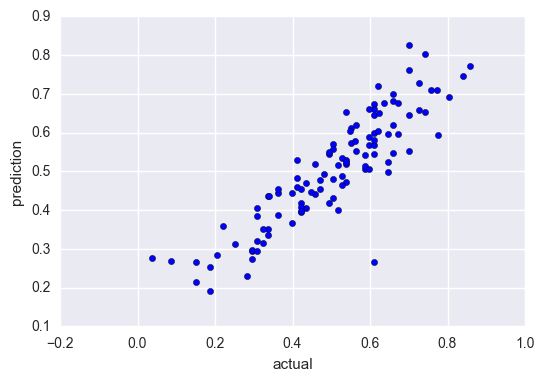

In [20]:
# calculate means of y_test and y_train
mean_y_test = np.mean(y_test)
mean_y_train = np.mean(y_train)

# print r_squared (train and test)
print 1 - (mean_squared_error(y_train, y_train_pred)/mean_squared_error([mean_y_train]*len(y_train), y_train))
print 1 - (mean_squared_error(y_test, y_test_pred)/mean_squared_error([mean_y_test]*len(y_test), y_test))

# Plot test vs test_pred
plt.scatter(y_test, y_test_pred)
plt.xlabel("actual")
plt.ylabel("prediction");

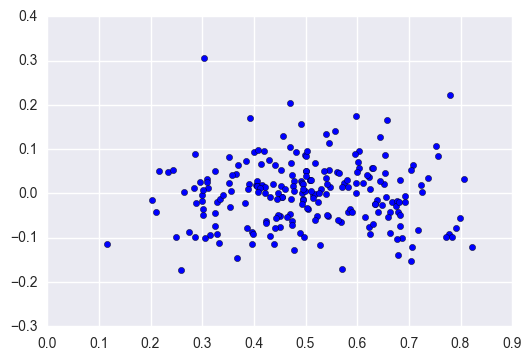

In [10]:
# Plot residuals
plt.scatter(est.predict(x_train), y_train - est.predict(x_train));

In [47]:
# Make the prediction on the whole dataset using the above model
X = X[feature_keep]
ttl_y_pred = est.predict(X)

In [49]:
# this is how I normalized earlier
# team_norm = (team_stats - team_stats.min()) / (team_stats.max() - team_stats.min())
# first_norm = (model_games - model_games.min()) / (model_games.max() - model_games.min())

# Un-normalize everything
# final_games = first_norm * (model_games.max() - model_games.min()) + model_games.min()
final_all = team_norm * (team_stats.max() - team_stats.min()) + team_stats.min()

In [50]:
# Drop the intercept
final_all = final_all.drop('intercept', 1)

In [54]:
# Open team_stats again to get the original data with team and season
with open("team_stats.pkl", 'rb') as picklefile:
    team_stats2 = pickle.load(picklefile)

In [63]:
# Add team and season back onto the dataframe
new1 = pd.concat([final_all.reset_index(drop = True),team_stats2[['team','season']].reset_index(drop = True)], axis=1)

In [80]:
# Add the predicted w/l ratio to the dataframe
new2 = pd.concat([new1.reset_index(drop=True), pd.DataFrame(ttl_y_pred).reset_index(drop=True)], axis=1)

In [81]:
# Un-log avg-wl and get rid of the log column
new2['avg_wl'] = np.exp(new2.log_avg_wl)
new2 = new2.rename(columns = {0: 'predicted_wl_norm'})

In [82]:
# Un-normalize the predicted column
final_all['log_pred_wl_ratio'] = team_norm['log_avg_wl'] * (team_stats['log_avg_wl'].max() - team_stats['log_avg_wl'].min()) + team_stats['log_avg_wl'].min()
final_all['pred_wl'] = np.exp(final_all.log_pred_wl_ratio)

In [83]:
new2['predicted_wl'] = new2['predicted_wl_norm'] * (team_stats['log_avg_wl'].max() - team_stats['log_avg_wl'].min()) + team_stats['log_avg_wl'].min()
new2['predicted_wl'] = new2['predicted_wl'].apply(lambda x:np.exp(x))

In [84]:
new2.head()

,avg_age,avg_fg3_pct,avg_fg_att,avg_pct_started,avg_per,avg_salary,avg_steals,log_avg_wl,opp_3_pct,opp_fg_att,opp_fg_pct,pace,strong_link,weak_link,team,season,predicted_wl_norm,avg_wl,predicted_wl
0,22.80,0.28,866.80,0.91,14.56,"4,992,921.60",73.00,-0.77,0.37,"6,433.00",0.48,90.40,0.75,-0.68,Atlanta_Hawks,2006,0.38,0.46,0.60
1,22.20,0.28,763.40,0.66,15.82,"5,066,493.80",68.40,-0.55,0.38,"6,335.00",0.47,90.00,0.75,-0.39,Atlanta_Hawks,2007,0.34,0.58,0.50
2,23.80,0.22,925.40,0.86,16.08,"7,488,752.00",76.60,-0.20,0.36,"6,733.00",0.46,91.10,0.48,-0.29,Atlanta_Hawks,2008,0.44,0.82,0.75
3,24.80,0.28,898.00,0.86,16.94,"9,775,806.60",77.20,0.29,0.35,"6,609.00",0.45,89.60,0.35,-0.30,Atlanta_Hawks,2009,0.53,1.34,1.10
4,25.80,0.41,908.00,0.97,17.08,"8,760,402.20",80.80,0.60,0.34,"6,623.00",0.46,90.10,0.43,-0.30,Atlanta_Hawks,2010,0.56,1.83,1.25


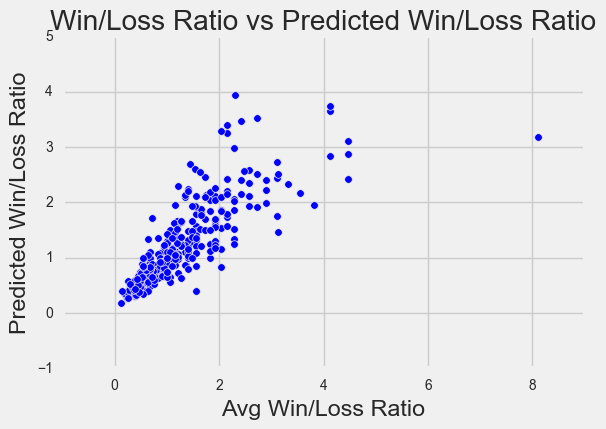

In [107]:
# Plot predicted win loss ratio vs the actual win/loss ratio un-normalized and no logs
new2['wl_diff'] = new2['avg_wl'] - new2['predicted_wl']
new2.loc[new2.season == 2016, ].sort_values(['wl_diff'])
with plt.style.context('fivethirtyeight'):
    plt.scatter(new2['avg_wl'], new2['predicted_wl'], s = 30, marker = 'o')
    plt.xlabel('Avg Win/Loss Ratio')
    plt.ylabel('Predicted Win/Loss Ratio')
    plt.title('Win/Loss Ratio vs Predicted Win/Loss Ratio')
    plt.show()

In [105]:
# Small comparison of Cleveland Cavs and Golden State Warriors for the powerpoint 
cols_needed = ['team', 'season', 'predicted_wl', 'avg_wl', 'wl_diff', 'avg_per', 'avg_age', 'opp_fg_pct', 'avg_salary', 'weak_link', 'strong_link']
gs_cle = new2.ix[(new2.season == 2016) & (new2.team.isin(['Cleveland_Cavaliers', 'Golden_State_Warriors'])), cols_needed].reset_index()
gs_cle.ix[:,1:12]

,team,season,predicted_wl,avg_wl,wl_diff,avg_per,avg_age,opp_fg_pct,avg_salary,weak_link,strong_link
0,Cleveland_Cavaliers,2016,2.06,2.28,0.22,18.68,28.00,0.45,"13,433,400.00",-0.48,0.63
1,Golden_State_Warriors,2016,3.19,8.11,4.93,19.52,26.20,0.43,"11,408,836.80",-0.48,0.49
